# Tutorial: Reversible-Jump MCMC in Gen _(with applications to Program Synthesis)_

### What is this notebook about?

In earlier tutorials, we saw how to write custom Metropolis-Hastings proposals and stitch them together to craft our own MCMC algorithms. Recall that to write a custom MH proposal, it was necessary to define a generative function that accepted as an argument the previous trace, and proposed a new trace *by "acting out" the model*, that is, by sampling new proposed values of random choices _at the same addresses used by the model_.

For example, a random walk proposal for the addresses `:x` and `:y` might have looked like this:

```julia
@gen function random_walk_proposal(previous_trace)
    x ~ normal(previous_trace[:x], 0.1)
    y ~ normal(previous_trace[:y], 0.2)
end
```

This pattern implies a severe restriction on the kinds of proposals we can write: the new `x` and `y` values must be sampled directly from a Ggen distribution (e.g., `normal`). For example, it is impossible to use this pattern to define a proposal that deterministcally *swaps* the current `x` and `y` values.

In this notebook, you'll learn a more flexible approach to defining custom MH proposals. The technique is widely applicable, but is particularly well-suited to models with discrete and continuous parameters, where the discrete parameters determine _which_ continuous parameters exist.

The polynomial curve-fitting demo we saw in the last problem set is one simple example: the discrete parameter `degree` determines which coefficient parameters exist. This situation is also common in program synthesis: discrete variables determine a program's structure, but the values inside the program may be continuous.


## Outline

**Section 1.** [Recap of the piecewise-function model](#piecewise-constant)

**Section 2.** [Basic Metropolis-Hastings inference](#basic-mh)

**Section 3.** [Reversible-Jump "Split-Merge" proposals](#split-merge)

**Section 4.** [Bayesian program synthesis of GP kernels](#synthesis)

**Section 5.** [A tree regeneration proposal](#tree-regen)

In [1]:
using Gen, Plots, Logging
include("dirichlet.jl")

Logging.disable_logging(Logging.Info);

## 1. Recap of the piecewise-constant function model  <a name="piecewise-constant"></a>

In [the intro to modeling tutorial](Introduction%20to%20Modeling%20in%20Gen.ipynb), you worked with a model of _piecewise constant_ functions, with unknown changepoints. Here, we model the same scenario, but somewhat differently.

Given a dataset of `xs`, our model will randomly divide the range `(xmin, xmax)` 
into a random number of segments.

It does this by sampling a number of segments (`:segment_count`), then
sampling a vector of _proportions_ from a Dirichlet distribution
(`:fractions`). The vector is guaranteed to sum to 1: if there are, say, three
segments, this vector might be `[0.3, 0.5, 0.2]`. The length of each segment
is the fraction of the interval assigned to it, times the length of the entire
interval (e.g., the third segment above would be length `0.2 * (xmax - xmin)`). 
For each segment, we generate a `y` value from a normal distribution.
Finally, we sample the `y` values near the piecewise constant function
described by the segments.

### Using `@dist` to define new distributions for convenience 
To sample the number of segments, we need a distribution with support only on
the positive integers. We create one using the [`@dist` DSL](https://www.gen.dev/dev/ref/distributions/#dist_dsl-1):

In [2]:
# A distribution that is guaranteed to be 1 or higher.
@dist poisson_plus_one(rate) = poisson(rate) + 1;

Distributions declared with `@dist` can be used to make random choices inside
of Gen models, just like native Gen distributions like `poisson` or
`bernoulli`. Behind the scenes, `@dist` has analyzed the code and figured out
how to evaluate the `logpdf`, or log density, of our newly defined
distribution. So we can ask, e.g., what the density of `poisson_plus_one(1)`
is at the point `3`:



In [4]:
logpdf(poisson_plus_one, 3, 1)

-1.6931471805599454

Note that this is the same as the logpdf of `poisson(1)` at the point `2` —
`@dist`'s main job is to automate the logic of converting the above call into
this one:

In [4]:
logpdf(poisson, 2, 1)

-1.6931471805599454

### Writing the model

We can now write the model itself. It is relatively straightforward, though there 
are a few things you may not have seen before:

* *List comprehensions* allow you to create a list without writing an entire
  for loop. For example, `[{(:segments, i)} ~ normal(0, 1) for i=1:segment_count]`
  creates a list of elements, one for each `i` in the range `[1, ..., segment_count]`, 
  each of which is generated using the expression `{(:segments, i)} ~ normal(0, 1)`.

* The [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution) is
  a distribution over the *simplex* of vectors whose elements sum to 1. We use it to
  generate the fractions of the entire interval (x_min, x_max) that each segment of our
  piecewise function covers.
  
* The logic to generate the `y` points is as follows: we compute the cumulative
  fractions `cumfracs = cumsum(fractions)`, such that `xmin + (xmax - xmin) * cumfracs[j]` is
  the x-value of the right endpoint of the `j`th segment.  Then we sample at each
  address `(:y, i)` a normal whose mean is the y-value of the segment that
  contains `xs[i]`.

In [5]:
@gen function piecewise_constant(xs::Vector{Float64})
    # Generate a number of segments (at least 1)
    segment_count ~ poisson_plus_one(1)
    
    # To determine changepoints, draw a vector on the simplex from a Dirichlet
    # distribution. This gives us the proportions of the entire interval that
    # each segment takes up. (The entire interval is determined by the minimum
    # and maximum x values.)
    fractions ~ dirichlet([1.0 for i=1:segment_count])
    
    # Generate values for each segment
    segments = [{(:segments, i)} ~ normal(0, 1) for i=1:segment_count]
    
    # Determine a global noise level
    noise ~ gamma(1, 1)
    
    # Generate the y points for the input x points
    xmin, xmax = extrema(xs)
    cumfracs = cumsum(fractions)
    # Correct numeric issue: `cumfracs[end]` might be 0.999999
    @assert cumfracs[end] ≈ 1.0
    cumfracs[end] = 1.0

    inds = [findfirst(frac -> frac >= (x - xmin) / (xmax - xmin),
                      cumfracs) for x in xs]
    segment_values = segments[inds]
    for (i, val) in enumerate(segment_values)
        {(:y, i)} ~ normal(val, noise)
    end
end;

Let's understand its behavior by visualizing several runs of the model. 
We begin by creating a simple dataset of xs, evenly spaced between -5
and 5.

In [6]:
xs_dense = collect(range(-5, stop=5, length=50));

Don't worry about understanding the following code, which we use for
visualization.

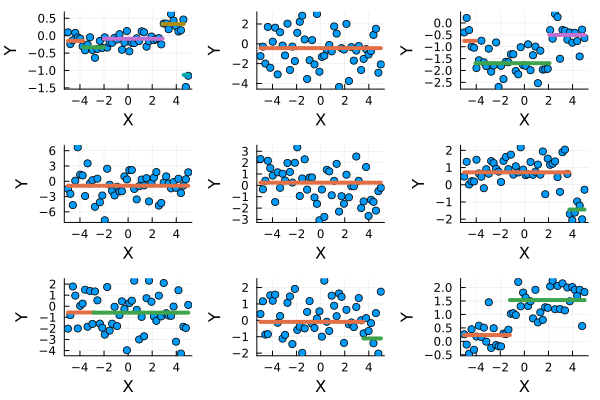

In [7]:
function trace_to_dict(tr)
    Dict(:values => [tr[(:segments, i)] for i=1:(tr[:segment_count])],
         :fracs  => tr[:fractions], :n => tr[:segment_count], :noise => tr[:noise],
         :ys => [tr[(:y, i)] for i=1:length(xs_dense)])
end;

function visualize_trace(tr; title="")
    xs, = get_args(tr)
    tr = trace_to_dict(tr)
    
    scatter(xs, tr[:ys], label=nothing, xlabel="X", ylabel="Y")
    
    cumfracs = [0.0, cumsum(tr[:fracs])...]
    xmin = minimum(xs)
    xmax = maximum(xs)
    for i in 1:tr[:n]
        segment_xs = [xmin + cumfracs[i] * (xmax - xmin), xmin + cumfracs[i+1] * (xmax - xmin)]
        segment_ys = fill(tr[:values][i], 2)
        plot!(segment_xs, segment_ys, label=nothing, linewidth=4)
    end
    Plots.title!(title)
end

traces = [simulate(piecewise_constant, (xs_dense,)) for _ in 1:9]
plot([visualize_trace(t) for t in traces]...)

Many of the samples involve only one segment, but many of them involve more.
The level of noise also varies from sample to sample.

## 2. Basic Metropolis-Hastings inference <a name="basic-mh" />

Let's create three synthetic datasets, each more challenging than the last, to
test out our inference capabilities.

In [8]:
ys_simple  = ones(length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_medium  = Base.ifelse.(Int.(floor.(abs.(xs_dense ./ 3))) .% 2 .== 0,
                          2, 0) .+ randn(length(xs_dense)) * 0.1;
ys_complex = Int.(floor.(abs.(xs_dense ./ 2))) .% 5 .+ randn(length(xs_dense)) * 0.1;

We'll need a helper function for creating a choicemap of constraints from a
vector of `ys`:

In [9]:
function make_constraints(ys)
    choicemap([(:y, i) => ys[i] for i=1:length(ys)]...)
end;

As we saw in the last problem set, importance sampling does a decent job on
the simple dataset:

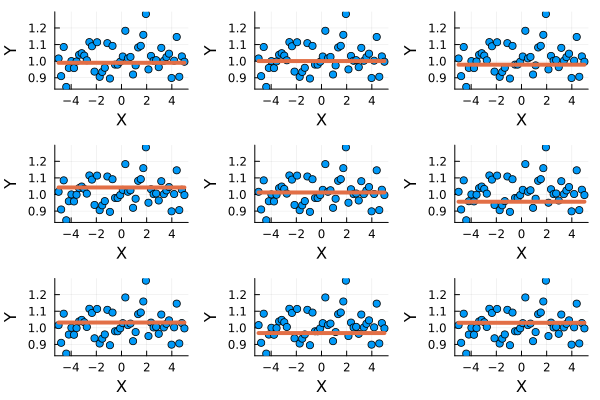

In [10]:
NUM_CHAINS = 9

traces = [first(importance_resampling(piecewise_constant, (xs_dense,), make_constraints(ys_simple), 5000)) for _ in 1:NUM_CHAINS]
Plots.plot([visualize_trace(t) for t in traces]...)

But on the complex dataset, it takes many more particles (here, we use 50,000)
to do even an OK job:

Log mean score: -41.165816596900285


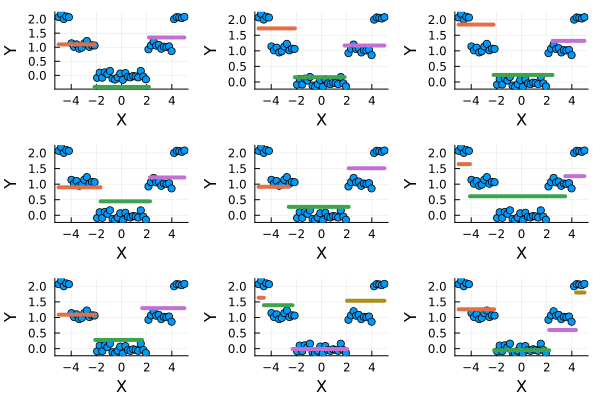

In [11]:
traces = [first(importance_resampling(piecewise_constant, (xs_dense,), make_constraints(ys_complex), 50000)) for _ in 1:9]
scores = [get_score(t) for t in traces]
println("Log mean score: $(logsumexp(scores)-log(NUM_CHAINS))")
Plots.plot([visualize_trace(t) for t in traces]...)

Let's try instead to write a simple Metropolis-Hastings algorithm to tackle the problem.

First, some visualization code (feel free to ignore it!).

In [12]:
function visualize_mh_alg(xs, ys, update, frames=200, iters_per_frame=1, N=NUM_CHAINS; verbose=true)    
    traces = [first(generate(piecewise_constant, (xs,), make_constraints(ys))) for _ in 1:N]
    viz = Plots.@animate for i in 1:frames
        
        if i*iters_per_frame % 100 == 0 && verbose
            println("Iteration $(i*iters_per_frame)")
        end
        
        for j in 1:N
            for k in 1:iters_per_frame
                traces[j] = update(traces[j], xs, ys)
            end
        end
       
        Plots.plot([visualize_trace(t; title=(j == 2 ? "Iteration $(i*iters_per_frame)/$(frames*iters_per_frame)" : "")) for (j,t) in enumerate(traces)]...)#, layout=l)
    end
    scores = [Gen.get_score(t) for t in traces]
    println("Log mean score: $(logsumexp(scores) - log(N))")
    gif(viz)
end;

And now the MH algorithm itself.

We'll use a basic Block Resimulation sampler, which cycles through the
following blocks of variables:
* Block 1: `:segment_count` and `:fractions`. Resampling these tries proposing
  a completely new division of the interval into pieces. However, it reuses
  the `(:segments, i)` values wherever possible; that is, if we currently have
  three segments and `:segment_count` is proposed to change to 5, only two new
  segment values will be sampled.

* Block 2: `:fractions`. This proposal tries leaving the number of segments
  the same, but resamples their relative lengths.

* Block 3: `:noise`. This proposal adjusts the global noise parameter.

* Blocks 4 and up: `(:segments, i)`. Tries separately proposing new values for
  each segment (and accepts or rejects each proposal independently).

In [13]:
function simple_update(tr, xs, ys)
    tr, = mh(tr, select(:segment_count, :fractions))
    tr, = mh(tr, select(:fractions))
    tr, = mh(tr, select(:noise))
    for i=1:tr[:segment_count]
        tr, = mh(tr, select((:segments, i)))
    end
    tr
end;

Our algorithm makes quick work of the simple dataset:

Iteration 100
Log mean score: 50.00788819778878


Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
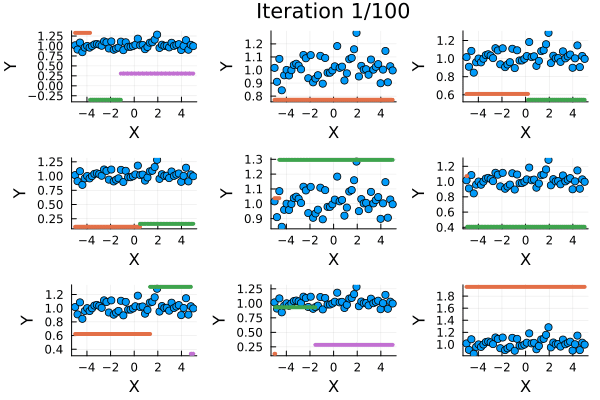

In [14]:
visualize_mh_alg(xs_dense, ys_simple, simple_update, 100, 1)

On the medium dataset, it does an OK job with less computation than we used in
importance sampling:

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Log mean score: 31.24863678509597


Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
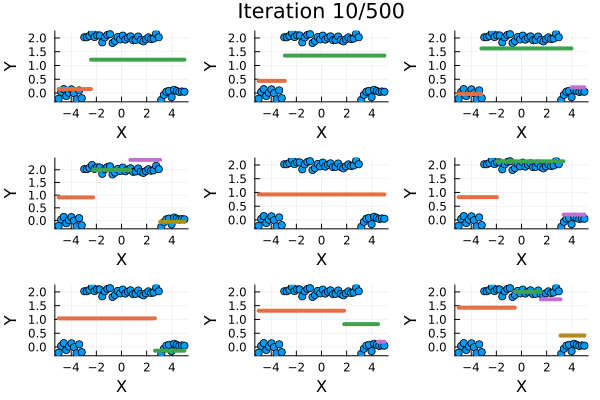

In [15]:
visualize_mh_alg(xs_dense, ys_medium, simple_update, 50, 10)

But on the complex dataset, it is still unreliable:

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Log mean score: -33.79177118265276


Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
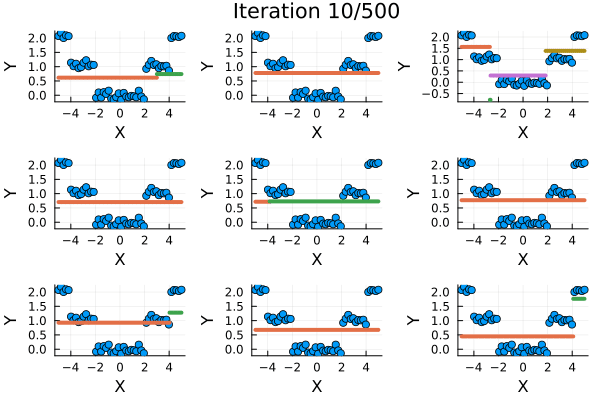

In [23]:
visualize_mh_alg(xs_dense, ys_complex, simple_update, 50, 10)

----

### Exercise

One problem with the simple block resimulation algorithm is that the proposals
for `(:segments, i)` are totally uninformed by the data. In this problem,
you'll write a custom proposal (using the techniques we covered in
Problem Set 1B) that uses the data to propose good values of `y` for each segment.

Write a generative function `segments_proposal` that can serve as a smart
proposal distribution for this problem. It should:

* Propose a new `:segment_count` from `poisson_plus_one(1)` (the prior).
* Propose a new `:fractions` from `dirichlet([1.0 for i=1:segment_count])`
  (the prior).
* In each segment, propose the function value `(:segments, i)` to be (a noisy
  version of) the average of the `y` values in our dataset from the given
  segment. Draw `(:segments, i)` from a normal distribution with that mean,
  and a small standard deviation (e.g. 0.3).

We will use this proposal to replace the "Block 1" move from our previous
algorithm. This should make it easier to have proposals accepted, because
whenever we propose a new segmentation of the interval, we propose it with
reasonable `y` values attached.

We have provided some starter code:

In [25]:
using Statistics


In [75]:
@gen function segments_proposal(t, xs, ys)
    xmin, xmax = minimum(xs), maximum(xs)
    x_range = xmax - xmin
    
    # Propose segment_count and fractions
    segment_count ~ poisson_plus_one(1)
    fractions ~ dirichlet([1.0 for i=1:segment_count])
    
    for i=1:segment_count
        min_x = xmin + x_range * sum(fractions[1:i-1])
        max_x = xmin + x_range * sum(fractions[1:i])
    
        filt1 = xs .>= min_x
        filt2 = xs .<= max_x
        
        good_ys = ys[filt1 .&& filt2]        
        {(:segments, i)} ~ normal(Statistics.mean(good_ys), 0.3)
    end
end;

We define `custom_update` to use `segments_proposal` in place of the first
block from `simple_update`.

In [76]:
function custom_update(tr, xs, ys)
    (tr, _) = mh(tr, segments_proposal, (xs, ys))
    (tr, _) = mh(tr, select(:fractions))
    (tr, _) = mh(tr, select(:noise))
    for i=1:(tr[:segment_count])
        (tr, _) = mh(tr, select((:segments, i)))
    end
    tr
end;

Let's see how this one does on each dataset:

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Log mean score: 29.963367912110552


Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
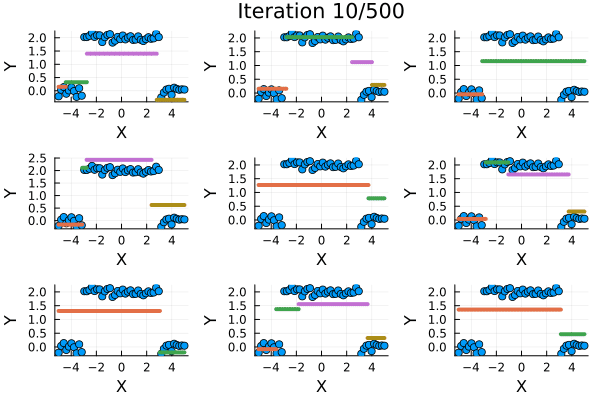

In [77]:
visualize_mh_alg(xs_dense, ys_medium, custom_update, 50, 10)

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Log mean score: -24.515258766641658


Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
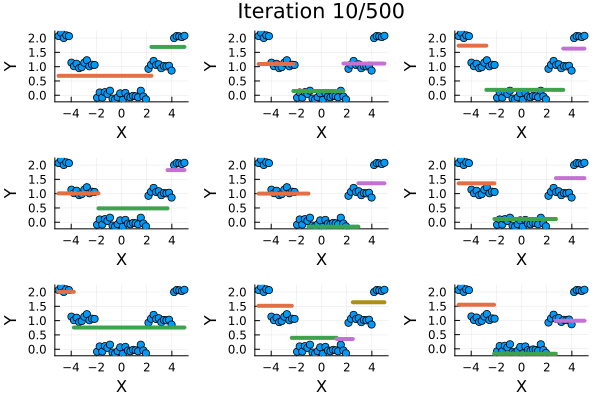

In [78]:
visualize_mh_alg(xs_dense, ys_complex, custom_update, 50, 10)

This will often outperform the simplest MH solution, but still leaves
something to be desired. The smart `segment_proposal` helps find good function
values for each segment, but doesn't help us in cases where the segment
proportions are wrong; in these cases, the model just decides that noise must
be high.

----
<!-- # BEGIN ANSWER KEY 2.9

@gen function segments_proposal(t, xs, ys)
    xmin, xmax = minimum(xs), maximum(xs)
    x_range = xmax - xmin
    segment_count ~ poisson_plus_one(1)
    fractions ~ dirichlet([1.0 for i=1:segment_count])
    
    for i=1:segment_count
        min = xmin + x_range * sum(fractions[1:i-1])
        max = xmin + x_range * sum(fractions[1:i])
        relevant_ys = [y for (x,y) in zip(xs,ys) if x >= min && x <= max]
        {(:segments, i)} ~ normal(sum(relevant_ys)/length(relevant_ys), 0.3)
    end
end;

# END ANSWER KEY -->

## 3. Involution MH for Split-Merge proposals <a name="split-merge" />

How might we improve on the MH algorithms from the previous section, to more
effectively search for good values of the `fractions` variable?

One approach is to add new proposals to the mix that _iteratively refine_ the
`fractions`, rather than relying on blind resimulation. A natural strategy
might be to add _split_ and _merge_ proposals:

* A _split_ chooses a segment to break into two pieces at a random point (and
  chooses new values for the two segments).
* A _merge_ chooses two adjacent segments to merge together into one segment
  (with a shared value).


### MCMC, Metropolis-Hastings, and Reversibility
Note that alone, neither of these two proposals makes for a valid
Metropolis-Hastings transition proposal. Why? One requirement of MCMC
algorithms is that each transition kernel (kernel, not proposal: **in MH, the
kernel includes the accept-reject step**) _leave the posterior distribution
stationary_. What does this mean? Suppose we somehow obtained an oracle that
let us sample a trace from the exact posterior, $t \sim p(t \mid
\text{observations})$. Then if we run an MCMC transition kernel $T$ on the
trace to obtain a new trace $t' \sim T(t' \leftarrow t)$, the marginal
distribution of $t'$ should still be the posterior. In simpler terms, no one
should be able to tell the difference between "traces sampled from the
posterior" (i.e., using the output of the oracle directly) and "traces sampled
from the posterior then sent through a transition kernel" (i.e., passing the
output of the oracle as the input to the transition kernel and using the
result). As a formula,

$$\int p(t \mid \text{observations}) \, T(t' \leftarrow t) \, \mathrm{d}t =
p(t' \mid \text{observations})$$

This is the stationarity requirement. Now suppose we set our transition kernel
$T$ to a Metropolis-Hastings `split` move. The `split` move _always_ increases
the number of segments. So if `t` comes from the true posterior, then the
distribution of `t'`, in terms of number of segments, will necessarily be
shifted upward (unless MH deterministically _rejects_ every proposal -- which
is what MH in Gen will do if given a `split` proposal). The same issue exists,
in reverse, for the `merge` proposal.

In general, this "stationarity" rule means that our Metropolis-Hastings
proposals must be *reversible*, meaning that if there is some probability that
a proposal can take you from one region of the state space to another, it must
also have some probability of sending you back from the new region to the old
region. If this criterion is satisfied, then the MH accept-reject step can
accept and reject proposals with the proper probabilities to ensure that the
stationarity property described above holds.

To make "split" and "merge" fulfill this "reversibility" criterion, we can
think of them as a constituting a *single* proposal, which *randomly chooses*
whether to split or merge at each iteration. This is an example of a
_reversible-jump_ proposal [1].

**References:**
1. Green, Peter J., and David I. Hastie. "Reversible jump MCMC." Genetics 155.3 (2009): 1391-1403.

### Implementing Split-Merge in Gen
This is a sensible proposal. But if we try to write this proposal in Gen, we
quickly hit several roadblocks. For example:

* The proposal needs to make several random choices that are *not* meant to
  serve as proposals for corresponding random choices in the model. For
  example, the proposal must decide whether to "split" or "merge," and then it
  needs to decide _at which index_ it will split or merge. But Gen interprets
  every traced random choice made by a proposal as corresponding to some
  choice in the model.
* Once we choose to split (or merge), it's unclear how we should propose to
  the various relevant addresses: from what distribution should the proposal
  sample `fractions`, for example? What we need is to propose a
  _deterministic_ value for `fractions`, _based on_ the random choices the
  proposal makes.

To get around these issues, Gen provides a variant of Metropolis-Hastings that
is a bit trickier to use but is ultimately more flexible.


The idea is this: first, we write a generative function that samples all the randomness
the proposal will require. In our case, this will involve

* choosing whether to split or merge
* choosing at what index the split or merge will happen
* if splitting, choosing where in a segment to split
* choosing new values for merged segments or newly created split segments

In [79]:
@gen function split_merge_proposal_randomness(t)
    old_n = t[:segment_count]
    
    # Choose whether to split (T) or to merge (F), keeping in mind
    # that if old_n == 1, then our decision is made for us
    # (split).
    if ({:split_or_merge} ~ bernoulli(old_n == 1 ? 1 : 0.3))
        
        # split
        # What index to split at?
        index ~ uniform_discrete(1,old_n)
        # Where is the splitting point, relative to the segment being split?
        split_percentage ~ uniform(0, 1)
        # New values for the two new segments
        new_value_1 ~ normal(t[(:segments, index)], 0.1)
        new_value_2 ~ normal(t[(:segments, index)], 0.1)
    else
        # merge
        # What index to merge at? (Merge index i and i + 1)
        index ~ uniform_discrete(1, old_n-1) # merge i and i+1
        
        # Sample a new value for the merged segment, near the mean of the
        # two existing segments' values.
        new_value ~ normal((t[(:segments, index)] + t[(:segments, index+1)]) / 2.0, 0.1)
    end
end;

Let's look at what this function samples:

In [80]:
tr, = generate(piecewise_constant, (xs_dense,), make_constraints(ys_complex,));
get_choices(simulate(split_merge_proposal_randomness, (tr,)))

│
├── :index : 1
│
├── :split_or_merge : false
│
└── :new_value : -0.3326732469559761


We now need to write an ordinary Julia function that tells Gen how to use the
proposal _randomness_ generated by the generative function above to create a
proposed next trace for Metropolis-Hastings.

The function takes four **inputs**:

* The previous trace, `t`
* The proposal randomness generated by our generative function above,
  `forward_choices`
* The return value, `forward_retval`, of the generative function we defined --
  we won't use this for now
* `proposal_args`: the arguments, other than `t`, that were used to generate
  `forward_choices` from the generative function written above. In our case,
  that function has no additional arguments, so this will always be empty.

It is supposed to return three **outputs**:

* `new_trace`: an updated trace to propose. We can construct this however we
  want based on `t` and `forward_choices`.
* `backward_choices`: a choicemap for the `proposal_randomness` generative
  function, capable of "sending `new_trace` back to the old trace `t`". For
  example, if we are enacting a `split` proposal, this would specify the
  precise `merge` proposal necessary to undo the split. This serves as "proof"
  that our proposal really is reversible.
* `weight`: usually, `get_score(new_trace) - get_score(t)`. The reason we need
  to return this is that it is possible to write proposals that need to return
  something different here; if your proposal involves deterministically
  transforming continuous random variables in non-volume-preserving ways, see
  the Gen documentation for details on how `weight` should change. In this
  notebook, `weight` will always be `get_score(new_trace) - get_score(t)`.

We call the Julia function an *involution*, because it must have the following
property. Suppose we had an old trace `old_trace`, and we propose a new trace
using `proposal_randomness_func` and then our Julia function `f`:

```
forward_choices = get_choices(simulate(proposal_randomness_func, (old_trace,)))
new_trace, backward_choices, = f(old_trace, forward_choices, ...)
```

Now suppose we use `backward_choices` and ask what `f` would do to
`new_trace`:

```
back_to_the_first_trace_maybe, backward_backward_choices, = f(new_trace, backward_choices, ...)
```

Then we require that `backward_backward_choices == forward_choices`, and that
`back_to_the_first_trace_maybe == old_trace`.

Here's an involution for Split-Merge:

In [81]:
function involution(t, forward_choices, forward_retval, proposal_args)
    # Goal: based on `forward_choices`, return a new trace
    # and the `backward_choices` required to reverse this
    # proposal.
    new_trace_choices = choicemap()
    backward_choices  = choicemap()
    
    # First, check whether we're dealing with a split or a merge.
    split_or_merge = forward_choices[:split_or_merge]
    
    # To reverse a split, use a merge (and vice versa)
    backward_choices[:split_or_merge] = !split_or_merge
        
    # Where is the split / merge occurring?
    # Reversing the proposal would use the same index.
    index = forward_choices[:index]
    backward_choices[:index] = index
    
    # Now we handle the segment values and proportions.
    # First, pull out the existing values from the previous
    # trace `t`. IMPORTANT NOTE: we need to `copy`
    # `t[:fractions]`, because we intend to perform mutating
    # Julia operations like `insert!` and `deleteat!` on it,
    # but do not wish to change the memory underlying the 
    # original trace `t` (in case the proposal is rejected
    # and we need to return to the original trace).
    fractions      = copy(t[:fractions])
    segment_values = [t[(:segments, i)] for i=1:t[:segment_count]]
    
    # How we update `fractions` and `segment_values` depends on
    # whether this is a split or a merge.
    if split_or_merge
        # If this is a split, then add a new element at `index`,
        # according to the split proportion.
        insert!(fractions, index, fractions[index] * forward_choices[:split_percentage])
        fractions[index + 1] *= (1 - forward_choices[:split_percentage])
        
        # Segment values
        backward_choices[:new_value] = segment_values[index]
        segment_values[index] = forward_choices[:new_value_1]
        insert!(segment_values, index, forward_choices[:new_value_2])
    else
        # If this is a merge, then combine the two segments `index`
        # and `index + 1`.
        proportion = fractions[index] / (fractions[index] + fractions[index + 1])
        fractions[index] += fractions[index + 1]
        deleteat!(fractions, index + 1)
        
        # Set the relevant segment values.
        backward_choices[:new_value_1] = segment_values[index]
        backward_choices[:new_value_2] = segment_values[index + 1]
        backward_choices[:split_percentage] = proportion
        segment_values[index] = forward_choices[:new_value]
        deleteat!(segment_values, index + 1)
    end
    
    # Fill a choicemap of the newly proposed trace's values
    new_trace_choices[:fractions] = fractions
    for (i, value) in enumerate(segment_values)
        new_trace_choices[(:segments, i)] = value
    end
    new_trace_choices[:segment_count] = length(fractions)
    
    # Obtain an updated trace matching the choicemap, and a weight (no change to the arguments)
    new_trace, weight, = update(t, get_args(t), (NoChange(),), new_trace_choices)
    (new_trace, backward_choices, weight)
end;

Look at the last two lines of the involution. The involution is responsible
for returning a *new trace*, not just a new *choicemap*. So, the common
pattern to follow in involutions is:

* Throughout the involution, fill a choicemap (here, `new_trace_choices`) with
  the updates that you want to make to the old trace `t`.
* At the end, call Gen's `update` function, passing in (1) the old trace `t`,
  (2) the model function's arguments, (3) a tuple of "argdiffs" (in our case,
  we know that the argument `xs` has not changed, so we pass in `NoChange()`),
  and (4) the choicemap of updates. `update` returns two useful values: the
  new trace, and a `weight`, which is equal to `get_score(t') - get_score(t)`.
  This is the weight we need to return from the involution.


We can create a new MH update that uses our proposal, and test it on the new
dataset:

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Log mean score: 35.86945140736324


Plots.AnimatedGif("/Users/derrickxiong/Documents/MIT/Fall 2022/9.66/project/gen-quickstart/tutorials/tmp.gif")
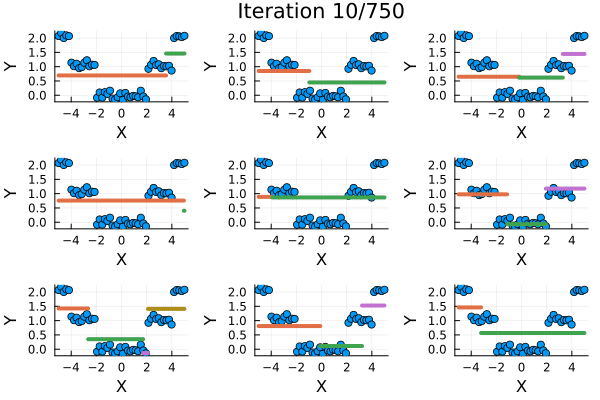

In [82]:
@gen function mean_segments_proposal(t, xs, ys, i)
    xmin, xmax = minimum(xs), maximum(xs)
    x_range = xmax - xmin
    fracs = t[:fractions]
    min = xmin + x_range * sum(fracs[1:i-1])
    max = xmin + x_range * sum(fracs[1:i])
    relevant_ys = [y for (x,y) in zip(xs,ys) if x >= min && x <= max]
    {(:segments, i)} ~ normal(sum(relevant_ys)/length(relevant_ys), 0.3)
end

function custom_update_inv(tr, xs, ys)
    tr, accepted = mh(tr, split_merge_proposal_randomness, (), involution)
    for i=1:tr[:segment_count]
        tr, = mh(tr, mean_segments_proposal, (xs, ys, i))
    end
    tr, = mh(tr, select(:noise))
    tr
end

visualize_mh_alg(xs_dense, ys_complex, custom_update_inv, 75, 10)

----

## Exercise

Here are some possible "improvements" to the above split-merge proposal, which
may sound reasonable, but which are all in fact _invalid_. For each, state why
it is invalid, and briefly describe a version of the suggested improvement
that _would_ be valid.

1. Proposed improvement: 
   make the `split` smarter, by always setting `split_proportion` to split
   somewhere between points `i` and `i+1`, where `i` and `i+1` are the two
   adjacent datapoints that have the largest $|y_i - y_{i+1}|$ value. The
   precise split proportion can still be random, drawn so that the split
   occurs uniformly between $x_i$ and $x_{i+1}$

2. Proposed improvement:
   when choosing an index to split or merge, make smart choices: when
   splitting, choose the segment that currently explains its data least well
   (according to the likelihood of the `y` points that fall on the segment),
   and when merging, choose the two adjacent segments whose existing values
   are closest to one another.
   
3. Proposed improvement:
   when splitting, do not sample `:new_value_1` and `:new_value_2` randomly;
   instead, in the involution, set them equal to the mean values of the
   datapoints that fall within their segment intervals.
   


1. This is not reversible, as if we merge two segments that are relatively close, we have probability 0 of splitting in that location again. Instead of always splitting there, instead we could split in a random location, but make it more likely based on the distance between $|y_i - y_{i + 1}|$.

2. Again, this is not reversible. If we merge two segments that are close to one another, we then could have no chance of splitting in that point if another segment is explained less well. Again, we can instead take probability distributions where we weight those merges/splits more heavily.
   
3. Once again, this is not reversible. If we start with two segments that are not set to their means (perhaps due to initialization), then we will never be able to split to get those segments back again. The fix is again to add some randomness, so that any new_value has at least some nonzero probability of occuring.

----
<!-- # BEGIN ANSWER KEY 2.10

"Improvement" 1: 
Why it's invalid: Not reversible: when we merge two datapoints, 
in order to re-split them, we may need the freedom of being able 
to split anywhere, not just within a promising interval.

Alternative approach: Make the split location random, but centered
around the midpoint of the x_i -> x_{i+1} interval.

"Improvement" 2: 
Why it's invalid: Not reversible; indeed, the split proposal will almost
never choose to split something that the merge proposal would have chosen
to have merged!

Alternative approach: Like in 1, these choices can also be made random--we
can use a "softmax" instead of a "max." But there will still be a problem:
the proposal would be technically reversible, but the acceptance rate would
still be very low, because smart splits are very unlikely to be reversed
by smart merges and vice versa. To mitigate this, we can use a "Smart Split-Dumb Merge,
Smart Merge-Dumb Split" pair of proposals.


"Improvement" 3: 
Why it's invalid: Not reversible: an arbitrary merge cannot be reversed by this split.

Alternative approach: Add some amount of noise to :new_value_1 and :new_value_2.


# END ANSWER KEY 
-->

## 4. Bayesian synthesis of Gaussian Process kernel programs  <a name="synthesis"></a>

We now consider a more complex model, adapted from the [Bayesian synthesis paper](https://popl19.sigplan.org/details/POPL-2019-Research-Papers/79/Bayesian-Synthesis-of-Probabilistic-Programs-for-Automatic-Data-Modeling) by Saad et al.

Our goal is to analyze time-series data: for some sequence of times $t_1, t_2, \dots, t_n$, we have observed points $x(t_1), x(t_2), \dots, x(t_n)$. We'll model a time series as arising from a Gaussian process with a particular _covariance kernel_. A covariance kernel is a function that takes in two times $t_1$ and $t_2$, and
computes a covariance between the random variables $x(t_1)$ and $x(t_2)$. Different covariance kernels can encode various structured patterns in the data. For example:

* A _squared exponential_ kernel assigns high covariance to pairs of time points that are nearby, and lower covariance to pairs of time points that are far away.  This kernel encodes a _smoothness_ prior: the time series does not change drastically from one moment to the next.

* A _periodic_ kernel assigns a covariance that depends on $\sin(f \cdot \lvert t_1 - t_2 \rvert)$ for some frequency $f$. This allows it to assign high covariance to points that lie the "right" distance from one another, but not too near or too far, encoding a periodic structure: the time series is highly correlated with itself, some time earlier.

* A _constant_ kernel encodes some constant covariance between $x(t_1)$ and $x(t_2)$, no matter what $t_1$ and $t_2$ are.

These primitive kernels can be composed in various ways, e.g., addition and multiplication, to encode more complex features of time series.

The main inference task we address in this section will be to infer a covariance kernel that captures the structure of a time series. In particular, given a dataset of $t_i$, $x(t_i)$ pairs, we would like to infer a covariance kernel `k` that makes the dataset likely under $GP(k)$, a Gaussian process with $k$ as a covariance kernel.

Covariance kernels will be represented by _expressions_ in a simple domain-specific language (DSL). The simplest of these expressions are primitive kernels, each of which comes with one or more parameters:

* `Constant(param :: Float64)`
* `Linear(param :: Float64)`
* `SquaredExponential(length_scale :: Float64)`
* `Periodic(scale :: Float64, period :: Float64)`

Smaller expressions can be combined into larger ones using _binary operations_ for addition and multiplication:

* `Plus(left, right)`
* `Times(left, right)`

Here, `left` and `right` are _other_ covariance kernel expressions.

An expression, like `Plus(Constant(0.3), Periodic(3.2, 1.9))`, can be viewed as a _syntax tree_.

Primitives form the leaf nodes of the tree; binary operations form the internal nodes, each of which has a `left` and `right` subtree. The code below defines this tree datatype for representing expressions, which we call `Kernel`.

In [26]:
import LinearAlgebra

"""Node in a tree representing a covariance function"""
abstract type Kernel end
abstract type PrimitiveKernel <: Kernel end
abstract type CompositeKernel <: Kernel end

"""
    size(::Kernel)
Number of nodes in the tree describing this kernel.
"""
Base.size(::PrimitiveKernel) = 1
Base.size(node::CompositeKernel) = node.size

"""Constant kernel"""
struct Constant <: PrimitiveKernel
    param::Float64
end


eval_cov(node::Constant, x1, x2) = node.param

function eval_cov_mat(node::Constant, xs::Vector{Float64})
    n = length(xs)
    fill(node.param, (n, n))
end


"""Linear kernel"""
struct Linear <: PrimitiveKernel
    param::Float64
end


eval_cov(node::Linear, x1, x2) = (x1 - node.param) * (x2 - node.param)

function eval_cov_mat(node::Linear, xs::Vector{Float64})
    xs_minus_param = xs .- node.param
    xs_minus_param * xs_minus_param'
end


"""Squared exponential kernel"""
struct SquaredExponential <: PrimitiveKernel
    length_scale::Float64
end


eval_cov(node::SquaredExponential, x1, x2) =
    exp(-0.5 * (x1 - x2) * (x1 - x2) / node.length_scale)

function eval_cov_mat(node::SquaredExponential, xs::Vector{Float64})
    diff = xs .- xs'
    exp.(-0.5 .* diff .* diff ./ node.length_scale)
end


"""Periodic kernel"""
struct Periodic <: PrimitiveKernel
    scale::Float64
    period::Float64
end


function eval_cov(node::Periodic, x1, x2)
    freq = 2 * pi / node.period
    exp((-1/node.scale) * (sin(freq * abs(x1 - x2)))^2)
end


function eval_cov_mat(node::Periodic, xs::Vector{Float64})
    freq = 2 * pi / node.period
    abs_diff = abs.(xs .- xs')
    exp.((-1/node.scale) .* (sin.(freq .* abs_diff)).^2)
end


"""Plus node"""
struct Plus <: CompositeKernel
    left::Kernel
    right::Kernel
    size::Int
end


Plus(left, right) = Plus(left, right, size(left) + size(right) + 1)


function eval_cov(node::Plus, x1, x2)
    eval_cov(node.left, x1, x2) + eval_cov(node.right, x1, x2)
end


function eval_cov_mat(node::Plus, xs::Vector{Float64})
    eval_cov_mat(node.left, xs) .+ eval_cov_mat(node.right, xs)
end


"""Times node"""
struct Times <: CompositeKernel
    left::Kernel
    right::Kernel
    size::Int
end


Times(left, right) = Times(left, right, size(left) + size(right) + 1)


function eval_cov(node::Times, x1, x2)
    eval_cov(node.left, x1, x2) * eval_cov(node.right, x1, x2)
end


function eval_cov_mat(node::Times, xs::Vector{Float64})
    eval_cov_mat(node.left, xs) .* eval_cov_mat(node.right, xs)
end;

More helper functions for evaluating covariances:

In [28]:
"""Compute covariance matrix by evaluating function on each pair of inputs."""
function compute_cov_matrix(covariance_fn::Kernel, noise, xs)
    n = length(xs)
    cov_matrix = Matrix{Float64}(undef, n, n)
    for i=1:n
        for j=1:n
            cov_matrix[i, j] = eval_cov(covariance_fn, xs[i], xs[j])
        end
        cov_matrix[i, i] += noise
    end
    return cov_matrix
end


"""Compute covariance function by recursively computing covariance matrices."""
function compute_cov_matrix_vectorized(covariance_fn, noise, xs)
    n = length(xs)
    eval_cov_mat(covariance_fn, xs) + Matrix(noise * LinearAlgebra.I, n, n)
end

"""
Computes the conditional mean and covariance of a Gaussian process with prior mean zero
and prior covariance function `covariance_fn`, conditioned on noisy observations
`Normal(f(xs), noise * I) = ys`, evaluated at the points `new_xs`.
"""
function compute_predictive(covariance_fn::Kernel, noise::Float64,
                            xs::Vector{Float64}, ys::Vector{Float64},
                            new_xs::Vector{Float64})
    n_prev = length(xs)
    n_new = length(new_xs)
    means = zeros(n_prev + n_new)
    cov_matrix = compute_cov_matrix(covariance_fn, noise, vcat(xs, new_xs))
    cov_matrix_11 = cov_matrix[1:n_prev, 1:n_prev]
    cov_matrix_22 = cov_matrix[n_prev+1:n_prev+n_new, n_prev+1:n_prev+n_new]
    cov_matrix_12 = cov_matrix[1:n_prev, n_prev+1:n_prev+n_new]
    cov_matrix_21 = cov_matrix[n_prev+1:n_prev+n_new, 1:n_prev]
    @assert cov_matrix_12 == cov_matrix_21'
    mu1 = means[1:n_prev]
    mu2 = means[n_prev+1:n_prev+n_new]
    conditional_mu = mu2 + cov_matrix_21 * (cov_matrix_11 \ (ys - mu1))
    conditional_cov_matrix = cov_matrix_22 - cov_matrix_21 * (cov_matrix_11 \ cov_matrix_12)
    conditional_cov_matrix = 0.5 * conditional_cov_matrix + 0.5 * conditional_cov_matrix'
    (conditional_mu, conditional_cov_matrix)
end

"""
Predict output values for some new input values
"""
function predict_ys(covariance_fn::Kernel, noise::Float64,
                    xs::Vector{Float64}, ys::Vector{Float64},
                    new_xs::Vector{Float64})
    (conditional_mu, conditional_cov_matrix) = compute_predictive(
        covariance_fn, noise, xs, ys, new_xs)
    mvnormal(conditional_mu, conditional_cov_matrix)
end;

### A prior over kernel programs

Our goal will be to infer a covariance kernel program that explains our time series.
To do this, we begin by placing a prior over covariance kernels. The main ingredient
will be the following distribution over Kernel Types:

In [29]:
kernel_types = [Constant, Linear, SquaredExponential, Periodic, Plus, Times]
@dist choose_kernel_type() = kernel_types[categorical([0.2, 0.2, 0.2, 0.2, 0.1, 0.1])];

It is essentially a categorical distribution, but one that outputs kernel types
instead of integers.

We then write a prior over kernels that uses `choose_kernel_type` recursively:

1. It first samples a parent kernel type using our `choose_kernel_type` distribution.
2. If the kernel is `Plus` or `Times`, it recursively calls itself to generate two sub-kernels
   (called `:left` and `:right`), and returns the composite kernel.
3. If the kernel is a primitive, then it samples the parameters from `uniform(0, 1)` distributions.
   (Note that `Periodic` kernels have two parameters, unlike the others, so we handle it specially.)

In [30]:
# Prior on kernels
@gen function covariance_prior()
    # Choose a type of kernel
    kernel_type ~ choose_kernel_type()

    # If this is a composite node, recursively generate subtrees
    if in(kernel_type, [Plus, Times])
        return kernel_type({:left} ~ covariance_prior(), {:right} ~ covariance_prior())
    end
    
    # Otherwise, generate parameters for the primitive kernel.
    kernel_args = (kernel_type == Periodic) ? [{:scale} ~ uniform(0, 1), {:period} ~ uniform(0, 1)] : [{:param} ~ uniform(0, 1)]
    return kernel_type(kernel_args...)
end;

Let's look at some sampled kernel programs from the model:

In [31]:
for i=1:10
    println(covariance_prior())
end

Linear(0.4315979003389019)
Times(Linear(0.7141058550679902), Constant(0.8194071069855731), 3)
Linear(0.6449166131203259)
Linear(0.5625723158537221)
Constant(0.8811213801811448)
Periodic(0.5371959381484374, 0.5272973482090528)
SquaredExponential(0.6620361852511123)
Plus(Linear(0.9549484580459537), SquaredExponential(0.3559697559402255), 3)
SquaredExponential(0.6956425597331438)
SquaredExponential(0.7390097920862906)


We see that there's a bias towards shorter programs. (Do you see why this is?) But we also see that longer programs are possible, including programs that include multiple `Times` or `Plus` nodes.

### Adding a likelihood to obtain a complete model

We now connect the kernel program to the observed data, by using it to compute
a covariance matrix and sampling from a multivariate normal distribution.

In [32]:
@dist gamma_bounded_below(shape, scale, bound) = gamma(shape, scale) + bound

# Full model
@gen function model(xs::Vector{Float64})
    
    # Generate a covariance kernel
    covariance_fn = {:tree} ~ covariance_prior()
    
    # Sample a global noise level
    noise ~ gamma_bounded_below(1, 1, 0.01)
    
    # Compute the covariance between every pair (xs[i], xs[j])
    cov_matrix = compute_cov_matrix_vectorized(covariance_fn, noise, xs)
    
    # Sample from the GP using a multivariate normal distribution with
    # the kernel-derived covariance matrix.
    ys ~ mvnormal(zeros(length(xs)), cov_matrix)
    
    # Return the covariance function, for easy printing.
    return covariance_fn
end;

Let's visualize a collection of traces from the model:

In [38]:
function visualize_gp_trace(tr, xmin, xmax; title="")
    curveXs = collect(Float64, range(xmin, length=100, stop=xmax))
    data_xs, = get_args(tr)
    data_ys = tr[:ys]
    curveYs = [predict_ys(get_retval(tr), 0.000001, data_xs, data_ys, curveXs) for i=1:50]
    fig = plot()
    for (i, curveYSet) in enumerate(curveYs)
        plot!(curveXs, curveYSet, title=title, xlims=(xmin, xmax), 
            label=nothing, color="lightgreen")
    end
    scatter!(data_xs, data_ys, color="black", label=nothing)
end;

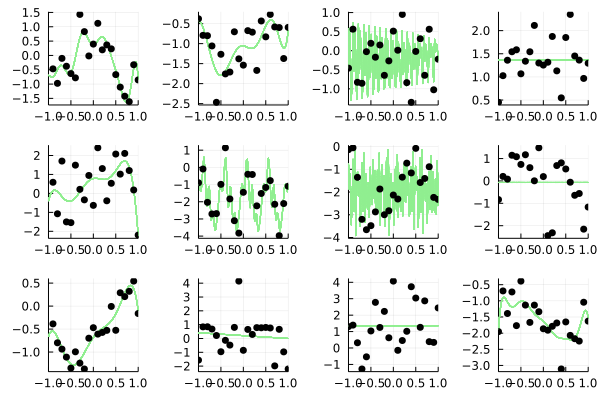

In [37]:
traces = [first(generate(model, (collect(Float64, -1:0.1:1),))) for i in 1:12]
plot([visualize_gp_trace(t, -1, 1) for t in traces]...)

As we can see, many different patterns can be expressed in the kernel language we developed.
Depending on the noise level, these patterns (green) may be more or less evident in the
generated dataset (gray).

## 5. A tree regeneration proposal <a name="tree-regen" />

We will use MCMC to find good covariance functions given a dataset.

First, we write a helper to generate an initial trace for a set of `xs`
and `ys`:

In [40]:
function initialize_trace(xs::Vector{Float64}, ys::Vector{Float64})
    tr, = generate(model, (xs,), choicemap(:ys => ys))
    return tr
end;

Next, we write a helper generative function that randomly chooses a node
in a kernel program's syntax tree. It starts at the root, and flips a coin
(at the address `:stop`) to decide whether to stop at the current node, 
or to descend further down the tree. (If it reaches a leaf node, it's done,
and `:stop` is `true` with 100% probability. Otherwise, the coin is fair.)

The generative function _returns_ a hierarchical address specifying where the
chosen node was sampled in the trace of the model. (This is for convenience later on.)

In [41]:
@gen function random_node_path(n::Kernel)
    if ({:stop} ~ bernoulli(isa(n, PrimitiveKernel) ? 1.0 : 0.5))
        return :tree
    else
        (next_node, direction) = ({:left} ~ bernoulli(0.5)) ? (n.left, :left) : (n.right, :right)
        rest_of_path ~ random_node_path(next_node)
        
        if isa(rest_of_path, Pair)
            return :tree => direction => rest_of_path[2]
        else
            return :tree => direction
        end
        
    end
end;

To understand how this works, let's generate a sample model trace.
(To make things interesting, we'll generate one where the first 
kernel node is guaranteed to be `Plus`.)

In [42]:
example_model_trace, = generate(model, ([0.],), choicemap((:tree => :kernel_type) => Plus));
display(get_choices(example_model_trace))

│
├── :ys : [0.55997821991224]
│
├── :noise : 1.6774670757202605
│
└── :tree
    │
    ├── :kernel_type : Plus
    │
    ├── :left
    │   │
    │   ├── :param : 0.7189479627699565
    │   │
    │   └── :kernel_type : Linear
    │
    └── :right
        │
        ├── :param : 0.3043898887791553
        │
        └── :kernel_type : Linear


The returned covariance kernel program is:

In [43]:
example_covariance_kernel = get_retval(example_model_trace)

Plus(Linear(0.7189479627699565), Linear(0.3043898887791553), 3)

Now, we can run our random node chooser:

In [44]:
random_node_chooser_trace = simulate(random_node_path, (example_covariance_kernel,));

Its return value is a path to a node in our model:

In [45]:
get_retval(random_node_chooser_trace)

:tree => :right

Its trace shows _how_ it arrived at this path.

In [46]:
display(get_choices(random_node_chooser_trace))

│
├── :left : false
│
├── :stop : false
│
└── :rest_of_path
    │
    └── :stop : true


Feel free to run the cells above a few times to get a hang for what's going on.

### An involution proposal for tree regeneration

We will use `random_node_path` to implement a _random subtree regeneration_ proposal.

It will:
* Choose a node using `random_node_path`.
* Generate a brand new tree, using `covariance_prior()`, to replace the subtree at the chosen node.

We begin by writing the "proposal randomness" function:

In [47]:
@gen function regen_random_subtree_randomness(prev_trace)
    path ~ random_node_path(get_retval(prev_trace))
    new_subtree ~ covariance_prior()
    return path
end;

And now we write the involution. Recall that the third argument
that the involution accepts is the _proposal return value_, in our
case, a model address (like `:tree => :left`) corresponding to where
a particular node and its children (i.e., a subtree) were generated
in the model trace.

In [49]:
function subtree_involution(trace, forward_choices, path_to_subtree, proposal_args)
    # Need to return a new trace, backward_choices, and a weight.
    backward_choices = choicemap()
    
    # In the backward direction, the `random_node_path` function should
    # make all the same choices, so that the same exact node is reached
    # for resimulation.
    set_submap!(backward_choices, :path, get_submap(forward_choices, :path))
    
    # But in the backward direction, the `:new_subtree` generation should
    # produce the *existing* subtree.
    set_submap!(backward_choices, :new_subtree, get_submap(get_choices(trace), path_to_subtree))
    
    # The new trace should be just like the old one, but we are updating everything
    # about the new subtree.
    new_trace_choices = choicemap()
    set_submap!(new_trace_choices, path_to_subtree, get_submap(forward_choices, :new_subtree))
    
    # Run update and get the new weight.
    new_trace, weight, = update(trace, get_args(trace), (UnknownChange(),), new_trace_choices)
    (new_trace, backward_choices, weight)
end;

We'll run our MCMC on a dataset of airline passenger volume over a number of years.

In [53]:
#########################
# load airline data set #
#########################
import CSV
using DataFrames: DataFrame
using StatsBase: mean
function get_airline_dataset()
    df = CSV.read("$(@__DIR__)/airline.csv", DataFrame)
    xs = collect(df[!, 1])
    ys = collect(df[!, 2])
    xs .-= minimum(xs) # set x minimum to 0.
    xs /= maximum(xs) # scale x so that maximum is at 1.
    ys .-= mean(ys) # set y mean to 0.
    ys *= 4 / (maximum(ys) - minimum(ys)) # make it fit in the window [-2, 2]
    return (xs, ys)
end;

In [54]:
(xs, ys) = get_airline_dataset();

Let's run it:

In [55]:
function run_mcmc(trace, frames::Int, iters_per_frame::Int)
    
    viz = @animate for frame=1:frames
        for iter in iters_per_frame
            trace, = mh(trace, regen_random_subtree_randomness, (), subtree_involution)
            trace, = mh(trace, select(:noise))
        end
        visualize_gp_trace(trace, minimum(xs), maximum(xs); title="Iter $(frame*iters_per_frame)/$(frames*iters_per_frame)")
    end
    
    println("Score: $(get_score(trace))")
    println("Final program:")
    println(get_retval(trace))
    gif(viz)
end;

Score: -63.45439408309837
Final program:
SquaredExponential(0.33663771835284306)


Plots.AnimatedGif("/Users/j/McGill/2022-01/PPL COMP596-LING483-683/Probabilistic Programming 2022/gen-quickstart/tutorials/tmp.gif")
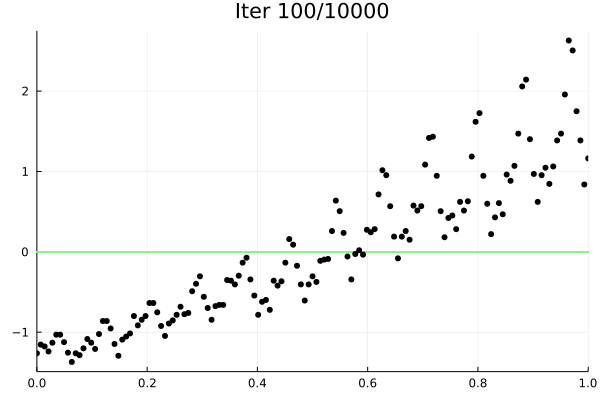

In [56]:
t = initialize_trace(xs, ys);
run_mcmc(t, 100, 100)